In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from utilities_namespace import *

In [2]:
from helpers.notebooks import notebooks_importer

In [3]:
%%capture
import Data as data

In [4]:
from signature_scoring.scoring_functions.gsea import create_gsea_scorer
from methods.gsea import cudaGSEA, GSEADesktop

In [5]:
from functools import partial

In [6]:
from signature_scoring.evaluation.benchmark import benchmark

In [7]:
from signature_scoring.evaluation.display import summarize

In [8]:
standard_benchmark = partial(
    benchmark,
    top='quantile',                           # criterium for selection of the candidated repositioning substances; quantile: choose top 10%
    summary='per_cell_line_combined',         # use combine() method of evaluation metrics to combine metrics results calculated for each of the cell lines
    aggregate='mean_per_substance_and_dose',  # same as "mean_per_substance_dose_and_cell" because summary is computed per cell line anyway (see above)
    cell_lines_ratio=.75,                     # at least such a ratio of substances signatures should be available for the cell line to include it
    limit=500,                                # how many under- and over- expressed genes should be analyzed
    processes=7,
    per_test_progress=False
)

In [9]:
standard_brca_benchmark = partial(
    standard_benchmark,
    query_signature=data.query_signature,
    indications_signatures=data.indications_singatures,
    contraindications_signatures=data.contraindications_singatures,  # TODO: typo in data
    control_signatures=data.all_control_signatures,
    query_expression=data.brca_with_controls
)

## Some notes on cudaGSEA

### Versions:
- Driver Version: 415.27
- CUDA Version: 10.0
- GeForce GTX 950M (640 GPU cores, 4046 MB)

cudaGSEA is executed one by one on the GPU core but the time when it is not being executed can be used to prepare the queue for the GPU core. So the number of processes basically tells how many tasks I wish to put on the queue.

Each task takes up to ~140 MB when 1000 permutations is used. My Nvidia card has 4046 MiB so it should be possible to have 28 processes up and waiting. However, in the benchmark below I use only seven cores as the Java version runs on CPU only.

### FDR calculation

cudaGSEA was published without FDR calculation, which is required for my scoring function.

I implemented FDR using two approaches:
 - as in the original GSEA paper (Subramanian, 2005) - the default one
 - reusing FDR-function from my previous implementation of GSEA (originally in Python) which do look at positive and negative NES scores separately - let's call it "approximate FDR"
 
The approximate FDR has lower complexity so it should be faster to calculate. Below I show that both the approaches produce values close to those generated by reference (Java) GSEA Desktop implementation.

Here is the link: : https://github.com/gravitino/cudaGSEA/compare/master...krassowski:with_approximate_fdr?expand=1

In [97]:
gsea_desktop = GSEADesktop()
gsea_cuda = cudaGSEA()
gsea_cuda_approx = cudaGSEA(fdr='approximate')
gsea_cuda_cpu = cudaGSEA(use_cpu=True) # same as gsea_cuda but calculated on CPU

# Results

## 1. My cudaGSEA FDR q-value algorithms  behave similarly to the reference GSEA Desktop implementation

The approximate FDR algorithm is much worse, but still better at approximating FDR than if we were just to look at the p-values.

Please see attached figure (about 10 cells below).

In [11]:
from data_sources.molecular_signatures_db import MolecularSignaturesDatabase

In [12]:
db = MolecularSignaturesDatabase()
db.load('c2.cp.kegg', 'entrez').trim(min_genes=15, max_genes=500).to_gmt('trimmed_kegg.gmt')

In [13]:
def benchmark_app(app):
    results = app.run(data.brca_with_controls, 'trimmed_kegg.gmt', id_type='entrez')
    return concat([results['normal'], results['tumor']])

In [14]:
result_desktop = benchmark_app(app=gsea_desktop)
result_cuda = benchmark_app(app=gsea_cuda)
result_cuda_approx = benchmark_app(app=gsea_cuda_approx)

In [15]:
fdr_comparison = DataFrame(dict(
    cuda_full_fdr=result_cuda['fdr_q-val'],
    desktop_fdr=result_desktop['fdr_q-val'],
    desktop_p=result_desktop['nom_p-val'],
    cuda_p=result_cuda['nom_p-val'],
    cuda_approx_fdr=result_cuda_approx['fdr_q-val']
))
# desktop_fdr is the reference
fdr_comparison = fdr_comparison.sort_values('desktop_fdr').reset_index().rename({'index': 'gene_set'}, axis=1)
fdr_comparison.head()

,gene_set,cuda_full_fdr,desktop_fdr,desktop_p,cuda_p,cuda_approx_fdr
0,KEGG_BASE_EXCISION_REPAIR,0.033178,0.022922,0.000000,0.003,0.040000
1,KEGG_HOMOLOGOUS_RECOMBINATION,0.027743,0.026554,0.004057,0.008,0.033500
2,KEGG_N_GLYCAN_BIOSYNTHESIS,0.032983,0.038720,0.001866,0.006,0.040200
3,KEGG_PYRIMIDINE_METABOLISM,0.033177,0.038872,0.003937,0.003,0.040333
4,KEGG_DNA_REPLICATION,0.017809,0.043339,0.002169,0.003,0.021500


In [16]:
to_plot = fdr_comparison.melt(id_vars=['gene_set'])
to_plot['gene_set'] = pd.Categorical(to_plot['gene_set'], ordered=True, categories=fdr_comparison.gene_set)
to_plot.head()

,gene_set,variable,value
0,KEGG_BASE_EXCISION_REPAIR,cuda_full_fdr,0.033178
1,KEGG_HOMOLOGOUS_RECOMBINATION,cuda_full_fdr,0.027743
2,KEGG_N_GLYCAN_BIOSYNTHESIS,cuda_full_fdr,0.032983
3,KEGG_PYRIMIDINE_METABOLISM,cuda_full_fdr,0.033177
4,KEGG_DNA_REPLICATION,cuda_full_fdr,0.017809


In [17]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

def pearsonr_score(x, y):
    return pearsonr(x, y)[0]

clean_comparison = fdr_comparison.dropna()

stats = DataFrame({
    stat.__name__: Series({
        other: stat(clean_comparison['desktop_fdr'], clean_comparison[other])
        for other in fdr_comparison.columns
        if other not in ['gene_set']
    })
    for stat in [r2_score, pearsonr_score]
})
stats

,r2_score,pearsonr_score
cuda_full_fdr,0.857390,0.945163
desktop_fdr,1.000000,1.000000
desktop_p,0.528161,0.963161
cuda_p,0.106576,0.742723
cuda_approx_fdr,0.704613,0.898028


In [47]:
annotations = stats.reset_index().rename({'index': 'variable'}, axis=1)
annotations.r2_score = annotations.r2_score.apply(lambda r2: f"R^{2}*'= {r2:.2f}'")
annotations.pearsonr_score = annotations.pearsonr_score.apply(lambda r: f'r = {r:.2f}')

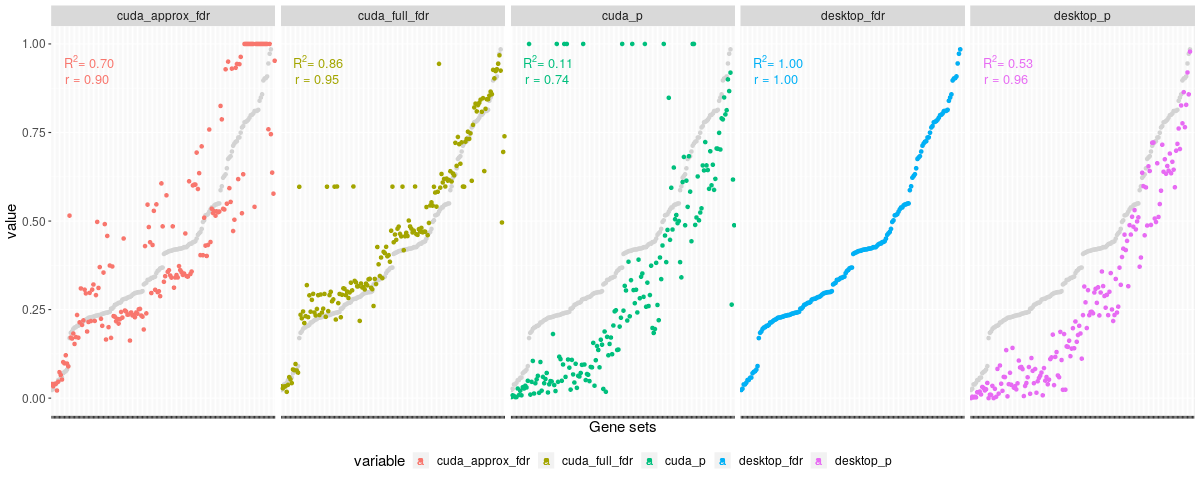

In [58]:
%%R -i to_plot -i annotations -w 1200
(
    ggplot(to_plot, aes(x=gene_set, y=value, color=variable))
    + geom_point(data=to_plot[to_plot$variable == 'desktop_fdr', c('gene_set', 'value')], color='lightgrey')
    + geom_text(data=annotations, aes(x=-Inf, y=0.95, label=r2_score), hjust=-0.25, parse=T, size=4.5)
    + geom_text(data=annotations, aes(x=-Inf, y=0.90, label=pearsonr_score), hjust=-0.315, size=4.5)
    + geom_point()
    + facet_grid('. ~ variable')
    + theme(axis.text.x = element_blank(), legend.position='bottom', legend.box='horizontal', text=element_text(size=15))
    + xlab('Gene sets')
)

## 2. cudaGSEA is on average 6 times faster (in the real scoring scenario)

Not two orders of magnitude as marketed by the original developers (though I do not have such a powerful card as they did - possibly my CPU is just relatively more powerful). So I do not say that the original method was not two orders of magnitue faster, but that after adding FDR and the cost of file preparation etc, the real benefit is only about 6 times speedup. 

In [11]:
tcga_genes = set(data.query_signature.index.astype(str))

In [12]:
shared_gsea_scorer = partial(
    create_gsea_scorer, gene_sets='c2.cp.kegg',
    permutation_type='phenotype', grouping='by_substance',
    verbose=False, genes=tcga_genes
)

In [12]:
speed_compared_functions = []

for p in [10, 50, 100, 500, 1000]:

    common_gsea_setup = partial(
        shared_gsea_scorer,
        permutations=p, q_value_cutoff=0.5,
    )

    gsea_score_phenotypes_java = common_gsea_setup(gsea_app=gsea_desktop, metric='Signal2Noise')
    gsea_score_phenotypes_cuda = common_gsea_setup(gsea_app=gsea_cuda, metric='twopass_signal2noise')
    gsea_score_phenotypes_cuda_approx = common_gsea_setup(gsea_app=gsea_cuda_approx, metric='twopass_signal2noise')
    gsea_score_phenotypes_cuda_approx.__name__= gsea_score_phenotypes_cuda_approx.__name__.replace('cudaGSEA', 'cudaGSEAapprox')
    gsea_score_phenotypes_cuda_cpu = common_gsea_setup(gsea_app=cudaGSEA(cpu=True), metric='twopass_signal2noise')
    gsea_score_phenotypes_cuda_cpu.__name__= gsea_score_phenotypes_cuda_cpu.__name__.replace('cudaGSEA', 'cudaGSEAcpu')

    speed_compared_functions.extend([
        gsea_score_phenotypes_cuda,
        gsea_score_phenotypes_cuda_approx,
        gsea_score_phenotypes_java,
        gsea_score_phenotypes_cuda_cpu
    ])

In [27]:
speed_benchmark_results = standard_brca_benchmark(speed_compared_functions)

'Iteration: 641/1000 for tmpgcr4au8q.tmp60y755_9'

'Iteration: 646/1000 for tmpgcr4au8q.tmp60y755_9'

'Iteration: 651/1000 for tmpgcr4au8q.tmp60y755_9'

'Iteration: 656/1000 for tmpgcr4au8q.tmp60y755_9'

'Iteration: 661/1000 for tmpgcr4au8q.tmp60y755_9'

In [28]:
speed_benchmark_results.to_csv('cudaGSEA benchmarks/speed_benchmark_results_with_cpu.csv')

In [236]:
speed_benchmark_data = DataFrame(dict(
    permutations=speed_benchmark_results.index.str.split('_').str[1].astype(int),
    app=pd.Categorical(speed_benchmark_results.index.str.split('_').str[0]),
    speed=speed_benchmark_results['Time'],
    auc=speed_benchmark_results['contraindications:AUC ROC'],
    auc_class=speed_benchmark_results['contraindications:AUC ROC classification'],
    f1=speed_benchmark_results['indications:F1 Score']
))

In [26]:
%load_ext rpy2.ipython

In [34]:
%%R
require(ggplot2)

In [83]:
desktop_performance = speed_benchmark_data.query('app == "GSEADesktop"')
for cuda_variant in ['cudaGSEA', 'cudaGSEAapprox', 'cudaGSEAcpu']:
    cuda_performance = speed_benchmark_data.query('app == @cuda_variant')
    merged = desktop_performance.merge(cuda_performance, on=['permutations'])
    speed_ratio = merged.speed_x / merged.speed_y
    print(f'mean(GSEADesktop / {cuda_variant}) = {speed_ratio.mean():.2f}')

mean(GSEADesktop / cudaGSEA) = 6.31
mean(GSEADesktop / cudaGSEAapprox) = 6.12
mean(GSEADesktop / cudaGSEAcpu) = 2.64


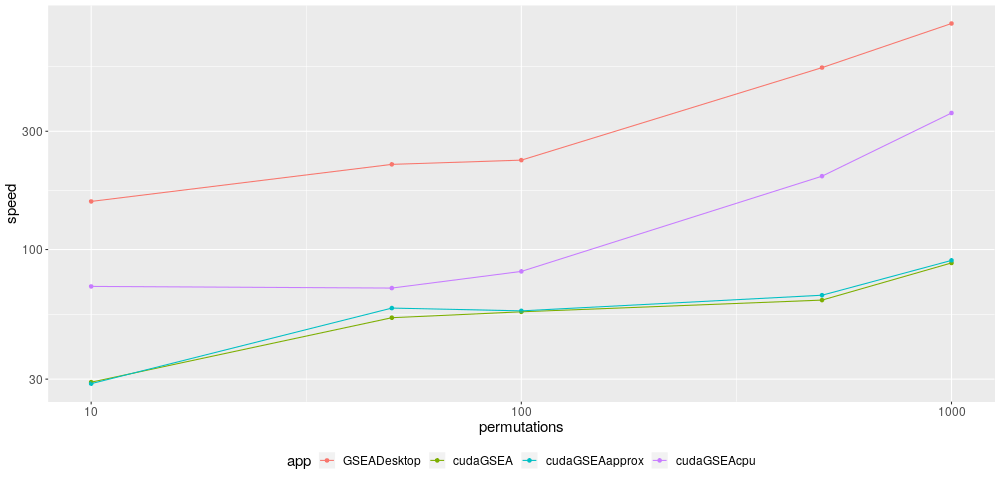

In [81]:
%%R -i speed_benchmark_data -w 1000
(
    ggplot(speed_benchmark_data, aes(x=permutations, y=speed, color=app))
    + geom_point()
    + theme(legend.position='bottom', legend.box='horizontal', text=element_text(size=15))
    + geom_line()
    + scale_y_continuous(trans='log10')
    + scale_x_continuous(trans='log10')

)

cudaGSEA cpu is the cuda implementation with the default (one-side) FDR calculation - but calculated on CPU, not graphic car. Still faster than the Java (GSEADesktop) implementation.

## 3. cudaGSEA yields results close to those of reference implementation

In [84]:
# or is it molten?
melted_data = speed_benchmark_data[['auc', 'f1', 'app']].melt(id_vars=['app'])

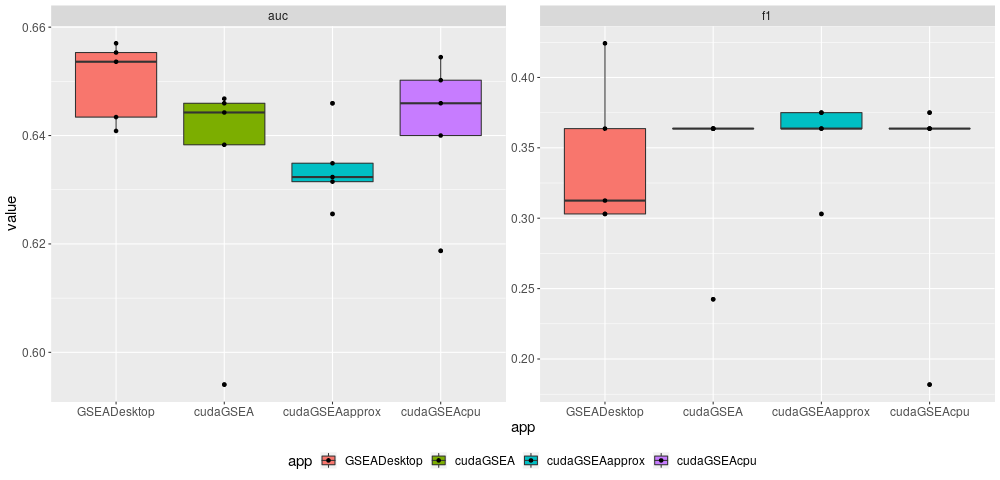

In [85]:
%%R -i melted_data -w 1000
(
    ggplot(melted_data, aes(x=app, y=value, fill=app))
    + facet_wrap('~ variable', scales='free_y')
    + geom_boxplot()
    + geom_point()
    + theme(legend.position='bottom', legend.box='horizontal', text=element_text(size=15))
)

On the above plot:
 - ROC AUC is calculated comparing row scores from signatures matching (floats normalized to 0-1, with 1 being for assumed indications) against a binary response vector (indications = 1, contraindications = 0)
 - F1 score is (obviously) calculated on a classification result, where indications were chosen as substances scoring above the threshold of top 10%.

Looking at the above plot it is difficult to interpret which method performs best:

- it may be that prioritization scores would have been better when using the reference GSEADesktop implementation,
- it may be that the cudaGSEA works better for classification problem.
- it seems likely that **there are just too few observations to draw solid conclusions.**

I somehow (weakly) support this claim below by showing how minuscule are the differences when compared to random distribution of the respective scores.

### How do those scores compare to a random distribution?

(given unequally distributed classes of indications and contraindications in this problem)

In [86]:
import random
from sklearn.metrics import f1_score, roc_auc_score
from data_sources.drug_connectivity_map import dcm

indications = len(dcm.identify_substances(data.indications_singatures))
contra = len(dcm.identify_substances(data.contraindications_singatures))

expected = [1] * indications + [0] * contra
indications / contra   # haven't found proof yet but simple ratio seems to give us expected f1 for unbalanced classes

0.34146341463414637

In [87]:
permutations_f1 = []
permutations_auc = []
permutations_classes = []
for i in range(1000):
    randomly_chosen = [random.choice([0, 1]) for j in range(indications + contra)]
    permutations_f1.append(f1_score(expected, randomly_chosen))
    permutations_classes.append(roc_auc_score(expected, randomly_chosen))

    randomly_chosen = [random.random() for j in range(indications + contra)]
    permutations_auc.append(roc_auc_score(expected, randomly_chosen))

In [88]:
permuatated = DataFrame(dict(
    f1=permutations_f1,
    auc=permutations_auc,
    auc_class=permutations_classes,
    app='permutations'
)).melt(id_vars='app')

In [89]:
melted_data = speed_benchmark_data[['auc', 'auc_class', 'f1', 'app']].melt(id_vars='app')
merged = concat([melted_data, permuatated])

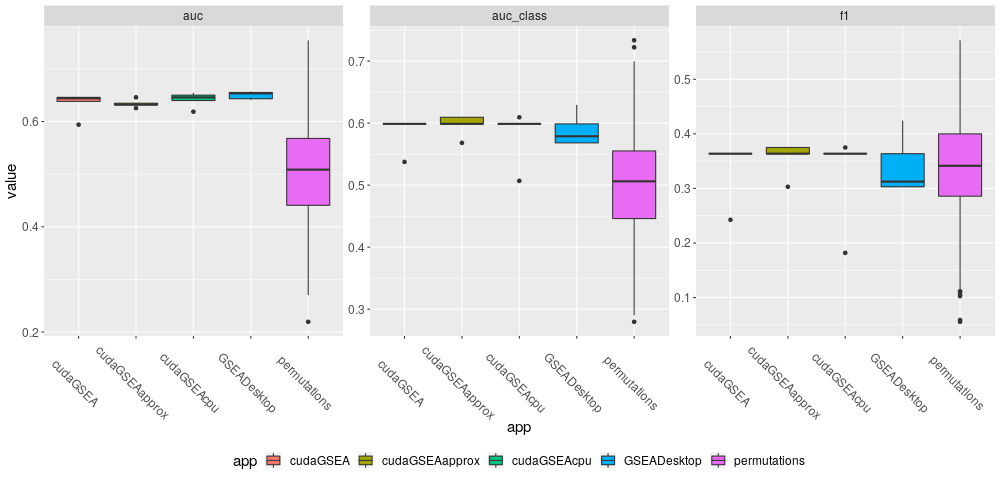

In [90]:
%%R -i merged -w 1000
(
    ggplot(merged, aes(x=app, y=value, fill=app))
    + facet_wrap('~ variable', scales='free_y')
    + geom_boxplot()
    + theme(legend.position='bottom', legend.box='horizontal', text=element_text(size=15), axis.text.x=element_text(angle=-45))
)

Here "auc_class" represents ROC AUC on classification result (obtained same way as for F1).

While F1 and AUC_class do seem highly correlated, F1 of GSEA Desktop (with given parameters) seems to be lower than expected BUT there are just too few repeats for GSEADesktop and I do not have power/time to compute more.

Below I take a closer look on two parameters for GSEA method: the FDR q-value cutoff and differential expression metrics.

## 4. Setting low FDR q-value cutoff results in low scoring function performance

In [13]:
import gc; gc.collect();

In [14]:
grid = [i/20 for i in range(1, 20)]
print(grid)

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]


In [15]:
p = 1000
functions = []
for q in grid:
    gsea_score_phenotypes_cuda = shared_gsea_scorer(
        gsea_app=gsea_cuda,
        permutations=p, q_value_cutoff=q,
        metric='onepass_signal2noise'
    )
    functions.append(gsea_score_phenotypes_cuda)

In [16]:
fdr_cutoff_benchmark = partial(standard_brca_benchmark, functions)
fdr_cutoff_benchmark.keywords['processes'] = 15

In [18]:
fdr_results = []

In [ ]:
for i in range(10):
    fdr_results.append(fdr_cutoff_benchmark())

In [22]:
results_q_cutoff = concat(fdr_results)

In [23]:
results_q_cutoff.to_csv('cudaGSEA benchmarks/results_q_cutoff_new.csv')

In [63]:
q_value_data = DataFrame(dict(
    q_cutoff=results_q_cutoff.index.str.split('_').str[4],
    indications_f1=results_q_cutoff['indications:F1 Score'],
    containdications_f1=results_q_cutoff['contraindications:F1 Score'],
    f1_tradeoff=results_q_cutoff['indications:F1 Score'] - results_q_cutoff['contraindications:F1 Score'],
    auc=results_q_cutoff['contraindications:AUC ROC'],
    auc_class=results_q_cutoff['contraindications:AUC ROC classification'],
)).melt(id_vars='q_cutoff')

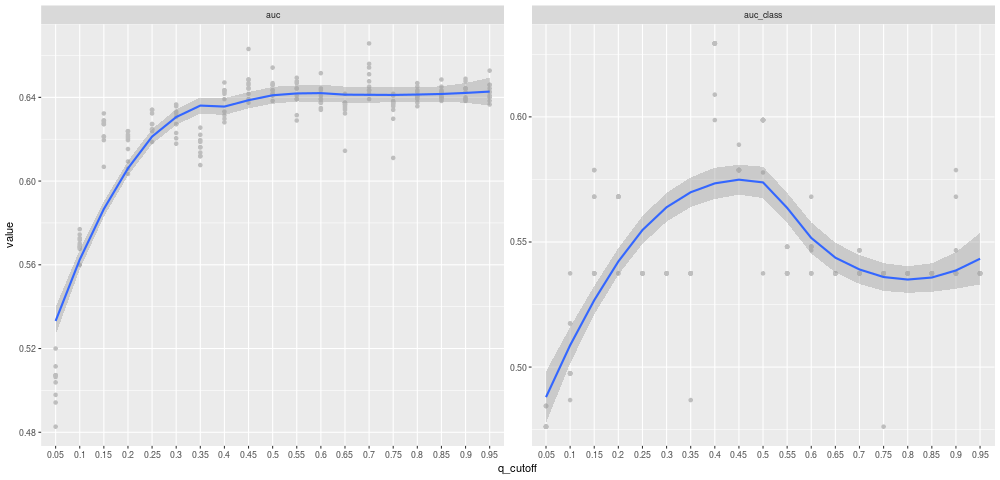

In [65]:
%%R -i q_value_data -w 1000
(
    ggplot(
        q_value_data[q_value_data$variable %in% c('auc', 'auc_class'),],
        aes(x=q_cutoff, y=value, group=variable)
    )
    + geom_point(color ='grey')
    + facet_wrap(' ~ variable', scales='free_y')
    + stat_smooth(show.legend=T)
)

It would seem that choosing an FDR q-value between 0.4-0.5 could give the best distinction here. But this would have to be tested on another dataset(!)

Why is that the case? Well, the FDR filtering is for me essentially a de-noising procedure (I use FDR q-value to select considered disease gene-sets and then set weight of accepted gene_set to $1-\text{qFDR}$). Filtering out man gene-sets (very low threshold) I loose noise as well as the signal. But I do not want to loose signal.

One might assume that there is a magic number 0.5 which should separate the gene sets which have a useful signal from those that are just a noise. This indeed seems to be the case.

Another consideration is the distribution of FDR q-values. By the definition/nature of FDR I expect that most of the q-values will be high, with just a small fraction below $0.05$. Thus setting FDR threshold to $0.05$ would eliminate a lot of the signal (and a lot of noise as well). Actually, this is shown on the first figure in this notebook.

**Notes:**
- the above results are only valid for the "one-tailed" FDR (which was used for the tests) 
- the above results should be reevaluated on another dataset.

##### Supplementary plot (F1 scores):

In this simple case contraindications F1 is just inverse of indications F1 (as there are no other classes, e.g. controls to compare with and affect the F1 class-specific scores) - so:

$\text{F1}_{\text{tradeoff}} = 2 \cdot \text{F1}_{\text{indications}} = -2 \cdot \text{F1}_{\text{contraindications}} \approx 2 \cdot \text{AUC}_{\text{class}}$

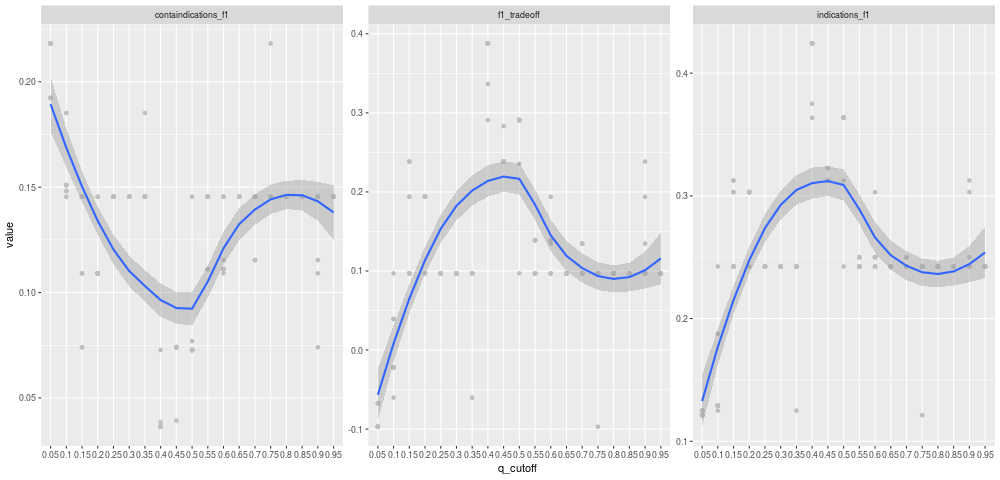

In [62]:
%%R -i q_value_data -w 1000
(
    ggplot(
        q_value_data[!q_value_data$variable %in% c('auc', 'auc_class'),],
        aes(x=q_cutoff, y=value, group=variable)
    )
    + geom_point(color ='grey')
    + facet_wrap(' ~ variable', scales='free_y')
    + stat_smooth(show.legend=T)
)

## 5. Naive metrics perform worse than the non-naive metrics \[pending recomputation\]

and (obviously) this does not change when we calculate the naive metrics with numerically stable algorithms.


There are no visible benefits of using numerically stable (two-pass/stable/overkill) implementations of signal-to-noise or t-test metrics.

**The part below was computed using approximate FDR (before the exact one was implemented). While the speed related findings will likely hold (and the general conclusion that naive metrics are worse than non-naive ones), the comparison may slightly change and there may be more findings with the new way of computing FDR. It will run overnight and I will update this part tomorrow.**

In [91]:
metrics = [
    'naive_diff_of_classes',
    'naive_ratio_of_classes',
    'naive_log2_ratio_of_classes',
    'stable_diff_of_classes',
    'stable_ratio_of_classes',
    'stable_log2_ratio_of_classes',
    'onepass_t_test',
    'onepass_signal2noise',
    'twopass_signal2noise',
    'twopass_t_test',
    'stable_signal2noise',
    'stable_t_test',
    'overkill_signal2noise',
    'overkill_t_test'
]
reduced_grid = [0.45, 0.5, 0.55]

In [99]:
p = 100
functions_metrics_test = []
for metric in metrics:
    for q in reduced_grid:
        gsea_score_phenotypes_cuda = shared_gsea_scorer(
            gsea_app=gsea_cuda,
            permutations=p, q_value_cutoff=q,
            metric=metric
        )
        functions_metrics_test.append(gsea_score_phenotypes_cuda)

In [100]:
metrics_benchmark = partial(standard_brca_benchmark, functions_metrics_test)
metrics_benchmark.keywords['processes'] = 25

In [ ]:
metrics_results = []
for i in range(5):
    result = metrics_benchmark()
    metrics_results.append(result)

In [ ]:
metrics_results = concat(metrics_results)

In [ ]:
metrics_results.to_csv('cudaGSEA benchmarks/metrics_results.csv')

In [121]:
metrics_data = DataFrame(dict(
    tradeoff=metrics_results['indications:F1 Score'] - metrics_results['contraindications:F1 Score'],
    metric=metrics_results.index.str.split('_').str[9:].str.join('_'),
    group=metrics_results.index.str.split('_').str[9],
    time=metrics_results['Time']
))

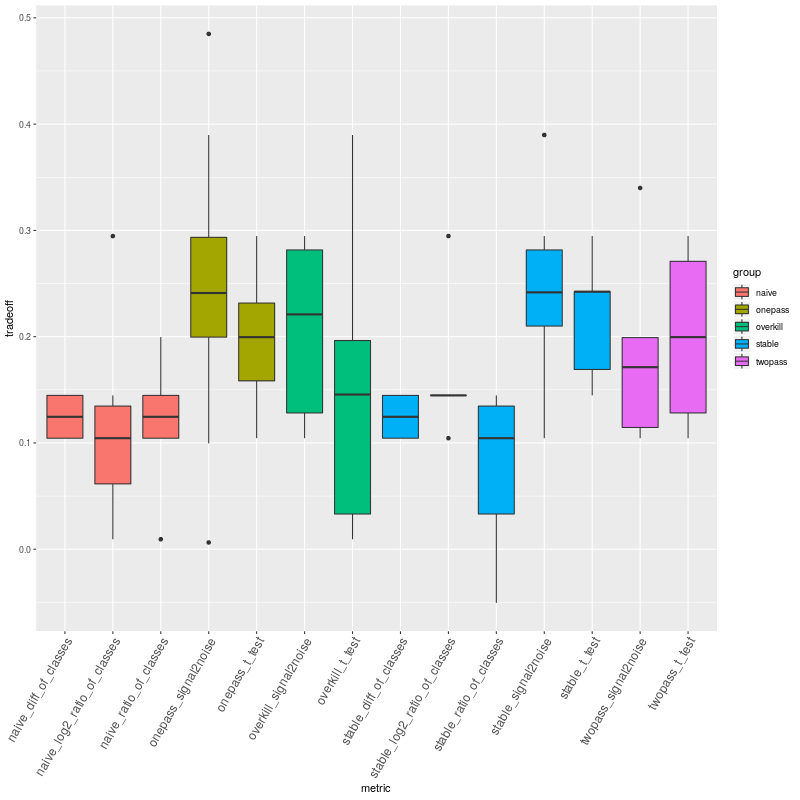

In [122]:
%%R -i metrics_data -w 800 -h 800 -u px
(
    ggplot(metrics_data, aes(x=metric, y=tradeoff, group=metric, fill=group))
    + geom_boxplot()
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
)

## 4. Naive metrics are faster.

Stable metrics appear to be faster, but it's only because there are stable implementations of naive metrics in this group.

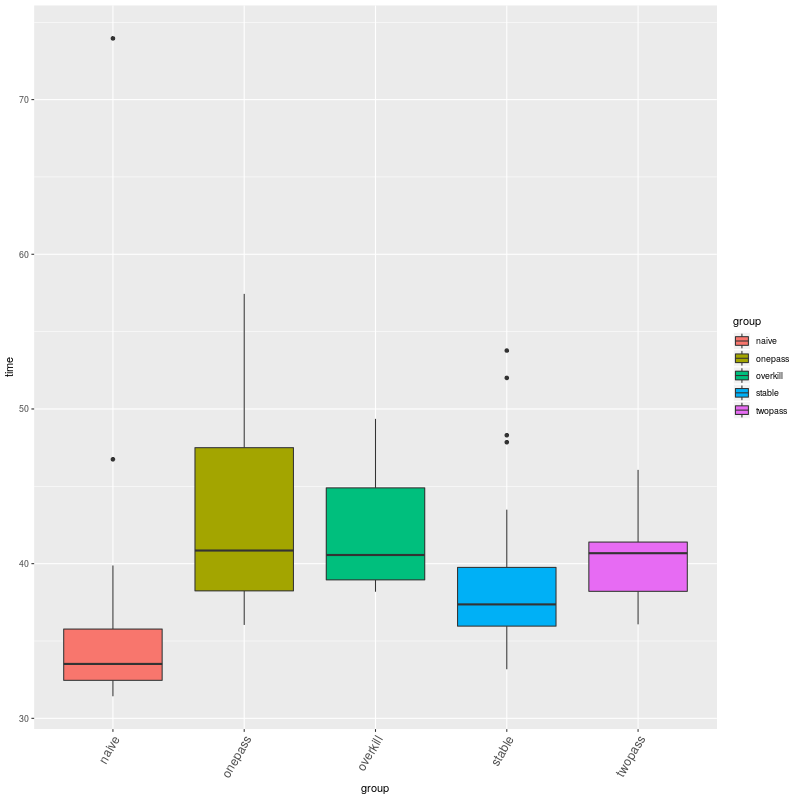

In [148]:
%%R -i metrics_data -w 800 -h 800 -u px
(
    ggplot(metrics_data, aes(x=group, y=time, group=group, fill=group))
    + geom_boxplot()
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
)

In [149]:
stable_limited = metrics_data[~metrics_data.metric.isin(
    ['stable_diff_of_classes', 'stable_log2_ratio_of_classes', 'stable_ratio_of_classes']
)]

Below one can see that there are no significant execution time differences among non-naive metrics:

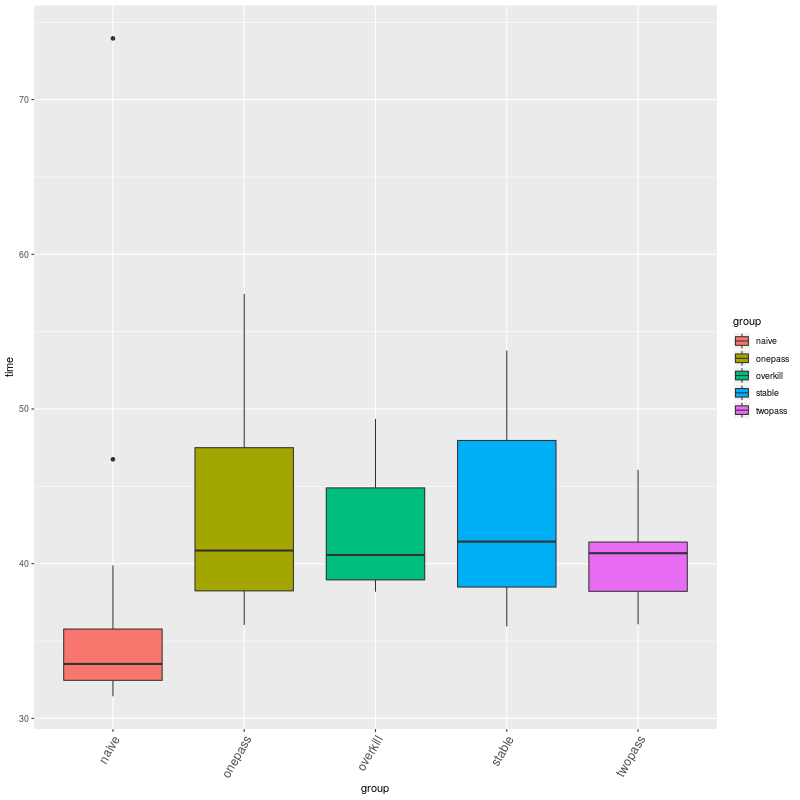

In [151]:
%%R -i stable_limited -w 800 -h 800 -u px
(
    ggplot(stable_limited, aes(x=group, y=time, group=group, fill=group))
    + geom_boxplot()
    + theme(axis.text.x=element_text(angle=60, hjust=1, size=12))
)

# Conclusions

- Using FDR approximation is not worth it (little or no speed-up, a lot of explaining why my method behaves differently from the standard GSEA implementation)
- q-FDR = 0.5 sounds like a good cutoff
- cudaGSEA should be used instead of GSEADesktop as it is 6 times faster
- using recommended two_pass_signal2ratio metric should give good speed / outcome tradeoff